In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image, ImageFile

import torch
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch import nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

In [2]:
from data.ent import ENTDataset

In [3]:
from models.simplecnn import SimpleNet

In [4]:
from tensorboardX import SummaryWriter

In [5]:
writer = SummaryWriter('/data/pytorch_workspace/logs/')

data_name = 'ent'
data_dir = '/data/entsurgery/data/'
train_data= os.path.join(data_dir,'mastoidectomay_data_train.csv')
val_data= os.path.join(data_dir,'mastoidectomay_data_val.csv')

img_dir = os.path.join(data_dir, 'images')
img_path_train= os.path.join(img_dir, 'train/')
img_path_val= os.path.join(img_dir, 'val/')

In [6]:
img_size = 256
batch_size = 8
model_name = 'vgg16_bn'

In [7]:
transformations = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )])

train_dataset = ENTDataset(train_data, img_path_train, transformations)
val_dataset = ENTDataset(val_data, img_path_val, transformations)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
if model_name == 'simplecnn':
    model = SimpleNet()
elif model_name == 'vgg16_bn':
    model = models.vgg16_bn(pretrained=True)
    # Number of filters in the bottleneck layer
    num_ftrs = model.classifier[6].in_features
    # convert all the layers to list and remove the last one
    features = list(model.classifier.children())[:-1]
    ## Add the last layer based on the num of classes in our dataset
    features.extend([nn.Linear(num_ftrs, 2)])
    ## convert it into container and add it to our model class.
    model.classifier = nn.Sequential(*features)


if torch.cuda.is_available():
    #torch.set_default_tensor_type('torch.cuda.FloatTensor')
    model = model.cuda() # On GPU
# freeze all model parameters for pretrained model
#if model_name is not 'simplecnn':
#    for param in model.parameters():
#        param.requires_grad = False
torch.backends.cudnn.benchmark = True
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = F.binary_cross_entropy_with_logits
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

data_loaders = {'train':train_loader, 'valid':val_loader}

In [11]:
# train by epoch
def train(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': dataloders['train'].__len__(), 
                     'valid': dataloders['valid'].__len__()}
    iterations = 0
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloders[phase]:
                iterations += 1
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda(async=True)), Variable(labels.cuda(async=True))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
               
                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs.data, 1)
                _, targets = torch.max(labels.data, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == targets).float() / batch_size

            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()
                best_iters = iterations
        
        writer.add_scalars('Loss', {'training': train_epoch_loss, 'validation': valid_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'training': train_epoch_acc, 'validation': valid_epoch_acc}, epoch)
                
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
                  'valid loss: {:.4f} acc: {:.4f}'.format(
                    epoch, num_epochs - 1,
                    train_epoch_loss, train_epoch_acc, 
                    valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 
               os.path.join(os.getcwd(), 'models/{}_{}_{}.pth'.format(data_name, model_name, repr(best_iters))))
    #writer.close()
    return model

In [ ]:
start_time = time.time()
model = train(data_loaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

  4%|▍         | 1/25 [07:05<2:50:09, 425.38s/it]

Epoch [0/24] train loss: 0.6036 acc: 0.7903 valid loss: 0.6337 acc: 0.7224


  8%|▊         | 2/25 [14:09<2:42:54, 424.99s/it]

Epoch [1/24] train loss: 0.6253 acc: 0.7451 valid loss: 0.6156 acc: 0.7540


 12%|█▏        | 3/25 [21:15<2:35:56, 425.28s/it]

Epoch [2/24] train loss: 0.5863 acc: 0.8141 valid loss: 0.6552 acc: 0.6853


 16%|█▌        | 4/25 [28:17<2:28:31, 424.36s/it]

Epoch [3/24] train loss: 0.5866 acc: 0.8269 valid loss: 0.5781 acc: 0.8474


 20%|██        | 5/25 [35:19<2:21:11, 423.57s/it]

Epoch [4/24] train loss: 0.5790 acc: 0.8439 valid loss: 0.6247 acc: 0.7487


 24%|██▍       | 6/25 [42:20<2:13:54, 422.88s/it]

Epoch [5/24] train loss: 0.5740 acc: 0.8522 valid loss: 0.6343 acc: 0.7277


 28%|██▊       | 7/25 [49:24<2:06:57, 423.21s/it]

Epoch [6/24] train loss: 0.5802 acc: 0.8371 valid loss: 0.5839 acc: 0.8259


 32%|███▏      | 8/25 [56:30<2:00:09, 424.07s/it]

Epoch [7/24] train loss: 0.5628 acc: 0.8708 valid loss: 0.5782 acc: 0.8349


 36%|███▌      | 9/25 [1:03:34<1:53:06, 424.14s/it]

Epoch [8/24] train loss: 0.5531 acc: 0.8965 valid loss: 0.5698 acc: 0.8562


In [15]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

In [16]:

def visualize_model(data_loder, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(data_loder):
        if  torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda(async=True)), Variable(labels.cuda(async=True))
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, 'Prediction: {}/Answer: {}'.format(
                'Left' if preds[j] == 0 else 'Right', 
                'Left' if labels.data[:,1][j] == 0 else 'Right'),
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

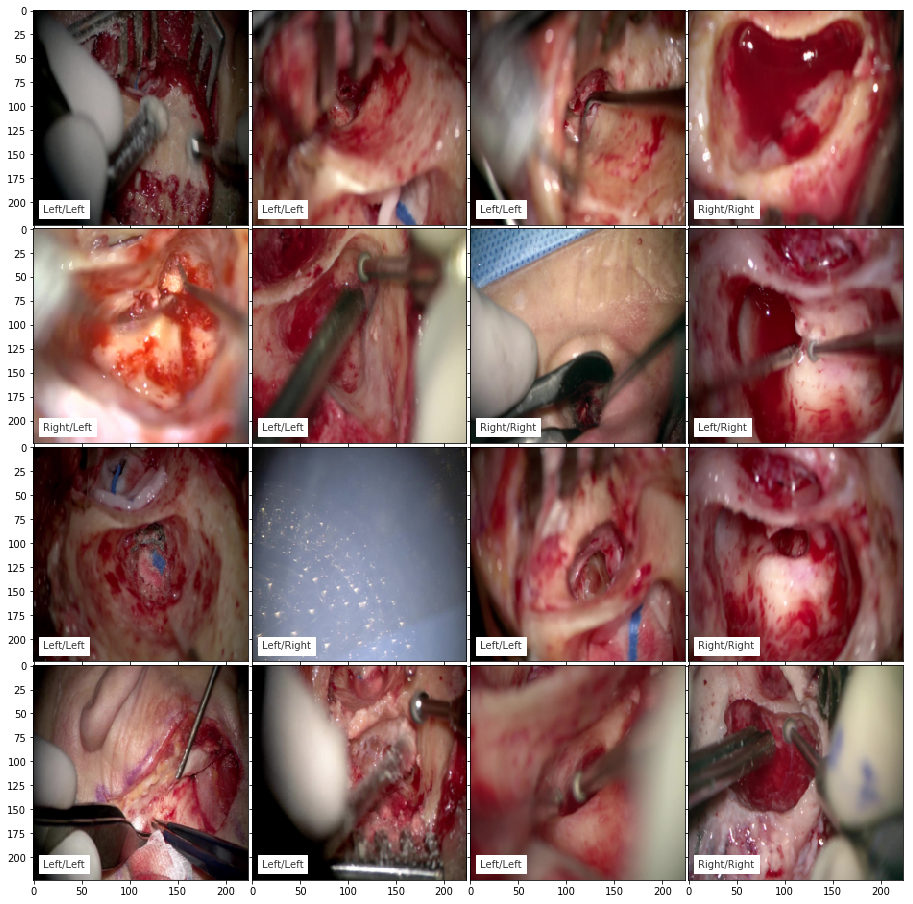

In [18]:
visualize_model(data_loaders['valid'], model)

In [19]:
test_data = os.path.join(data_dir, 'mastoidectomay_data_test.csv')
img_path_test=os.path.join(img_dir, 'test/')
test_dataset= ENTDataset(test_data, img_path_test, transformations)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [25]:
# train by epoch
def predict(test_loders, model, criterion, optimizer):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    dataset_size = test_loader.__len__()
    
    for inputs, labels in tqdm(test_loader):
        model.train(False)
        model.eval()
        #running_loss = 0.0
        #running_corrects = 0
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(async=True)), Variable(labels.cuda(async=True))
        else:
            inputs, labels = Variable(inputs), Variable(labels)
     
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        _, targets = torch.max(labels.data, 1)
        
        #running_loss += loss.data[0]
        #running_corrects += torch.sum(preds == targets).float() / batch_size
        torch.cuda.empty_cache()
        
    test_loss = running_loss / dataset_size
    test_acc = running_corrects / dataset_size        
    
    
    print('Test loss: {:4f} Test Acc: {:4f}'.format(test_loss, test_acc))
    
    return 

In [26]:
predict(test_loader, model, criterion, optimizer)

  0%|          | 0/711 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100%|██████████| 711/711 [01:29<00:00,  4.20it/s]

Test loss: 0.001058 Test Acc: 0.000176


In [ ]:
visualize_model(test_loader, model)